Цель проекта: Определить параметры для будущей модели, которая должна оценивать влияние 
условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике

Задача проекта: Провести разведывательный анализ данных на основе заданного датасета 
для получения набора  параметров влияющих на успеваемость учеников по математике.

Входные данные: набор из 30 параметров представленный в файле 'stud_math.csv', а также  описание этих параметров

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

 
pd.set_option('display.max_columns', 50)  # показывать больше колонок

stud = pd.read_csv('stud_math.csv')
display(stud.head(5))
stud.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Очевидно, сразу можно убрать строки с пропусками в целевом столбце 'score'.

In [2]:
stud = stud[stud.score.notna()]

Рассмотрим целевой столбец 'scores' более подробно:

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

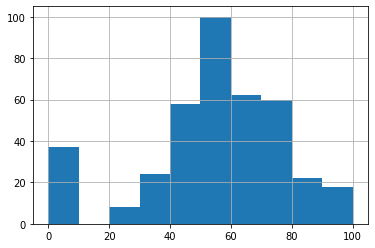

In [3]:
stud.score.hist()
stud.score.value_counts()

Распределение напоминает нормальное. При этом, и без перцентильного метода определения выбросов ясно, что нулевые значения стобца 'score' являются аномалиями, так как очень маловероятно, что существует заметное число (37)  студентов получивших 0 баллов и совсем нет получивших от 1 до 19 баллов. Поэтому придется отбросить все строки с значением 'score'= 0 и уменьшить датасет почти на 10%.

In [4]:
stud = stud[stud.score > 0]
stud.reset_index(inplace=True, drop=True)
len(stud)

352

In [5]:
stud.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

Переопределим наименования колонок:

In [6]:
new_columns = ['school', 'sex', 'age', 'address', 'fam_size', 'p_status', 'm_edu', 'f_edu',
               'm_job', 'f_job', 'reason', 'guardian', 'travel_time', 'study_time',
               'failures', 'schools_up', 'fams_up', 'paid', 'activities', 'nursery',
               'studytime_granular', 'higher', 'internet', 'romantic', 'fam_rel',
               'free_time', 'go_out', 'health', 'absences', 'score']

In [7]:
stud.columns = new_columns

Создадим копию датасета для дальнейшей работы (на всякий случай):

In [8]:
df = stud.copy()

Определим количество числовых и строковых столбцов:

In [9]:
# Числовые переменные:
df.select_dtypes(include=['float64', 'int64']).head(3)

,age,m_edu,f_edu,travel_time,study_time,failures,studytime_granular,fam_rel,free_time,go_out,health,absences,score
0,18,4.0,4.0,2.0,2.0,0.0,-6.0,4.0,3.0,4.0,3.0,6.0,30.0
1,17,1.0,1.0,1.0,2.0,0.0,-6.0,5.0,3.0,3.0,3.0,4.0,30.0
2,15,1.0,1.0,1.0,2.0,3.0,-6.0,4.0,3.0,2.0,3.0,10.0,50.0


In [10]:
print('Количество числовых столбцов:', len(
    df.select_dtypes(include=['float64', 'int64']).columns))

Количество числовых столбцов: 13


In [11]:
# Строковые переменные:
df.select_dtypes(include=['object']).head(3)

,school,sex,address,fam_size,p_status,m_job,f_job,reason,guardian,schools_up,fams_up,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,NaN,A,at_home,teacher,course,mother,yes,no,no,no,yes,yes,NaN,no
1,GP,F,U,GT3,NaN,at_home,other,course,father,no,yes,no,no,no,yes,yes,no
2,GP,F,U,LE3,T,at_home,other,other,mother,yes,no,NaN,no,yes,yes,yes,NaN


In [12]:
print('Количество строковых столбцов:', len(
    df.select_dtypes(include=['object']).columns))

Количество строковых столбцов: 17


Пользуясь предварительным описанием датасета, для дальнейшего анализа будет удобно определить класс переменной: "количественная", "ранговая" или "номинативная" 

In [13]:
var_class = {'school': 'nom', 'sex': 'nom', 'age': 'quant', 'address': 'nom', 'fam_size': 'nom', 'p_status': 'nom', 'm_edu': 'rank', 'f_edu': 'rank',
             'm_job': 'nom', 'f_job': 'nom', 'reason': 'nom', 'guardian': 'nom', 'travel_time': 'rank', 'study_time': 'rank',
             'failures': 'rank', 'schools_up': 'nom', 'fams_up': 'nom', 'paid': 'nom', 'activities': 'nom', 'nursery': 'nom',
             'studytime_granular': 'unknown', 'higher': 'nom', 'internet': 'nom', 'romantic': 'nom', 'fam_rel': 'rank',
             'free_time': 'rank', 'go_out': 'rank', 'health': 'rank', 'absences': 'quant', 'score': 'quant'}

In [14]:
nom_list = [i for i in df.columns if var_class[i] == 'nom']
print('Номинативные признаки:\n', nom_list)

Номинативные признаки:
 ['school', 'sex', 'address', 'fam_size', 'p_status', 'm_job', 'f_job', 'reason', 'guardian', 'schools_up', 'fams_up', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [15]:
rank_list = [i for i in df.columns if var_class[i] == 'rank']
print('Ранговые:\n', rank_list)

Ранговые:
 ['m_edu', 'f_edu', 'travel_time', 'study_time', 'failures', 'fam_rel', 'free_time', 'go_out', 'health']


In [16]:
quant_list = [i for i in df.columns if var_class[i] == 'quant']
print('Количественные:\n', quant_list)

Количественные:
 ['age', 'absences', 'score']


fam_size - эту строковую переменную можно было бы отнести и к классу ранговой переменной (переопределив числами), так как имеется возможность качественного сравнения значений(больше-меньше), однако в виду всего двух возможных значений примем ее за номинативную.

Большинство численных переменных датасета являются по сути упорядоченными категориальными (ранговыми) переменными с известным (из описания) набором осмысленных значений, поэтому для дальнейшей автоматизации обработки аномалий,создадим словарь допустимых значений:

In [17]:
valid_lims = {'age': range(15, 23), 'm_edu': range(5), 'f_edu': range(5), 'travel_time': range(1, 5), 'study_time': range(1, 5), 'failures': range(4),
              'studytime_granular': 'unknown', 'fam_rel': range(1, 6), 'free_time': range(1, 6), 'go_out': range(1, 6), 'health': range(1, 6),
              'absences': 'non-negative', 'score': 'non-negative'}

Для оценки количества пропусков и аномальных значений в числовых столбцах удобно ввести функцию:

In [18]:
def primary_analysis(col_name):
    ''' Функция предназначена для автоматического определения

    количества пропусков данных и наличия недопустимых значений

    в соответствии со словарем valid_lims, а также для вывода 

    уникальных значений.

    '''

    print('Первичный анализ столбца:', col_name)

    a_val = []

    # переведем пропуски в строковых данных в объект None
    if var_class[col_name] == 'nom':
        df[col_name] = df[col_name].astype(str).apply(lambda x: None if pd.isnull(x)
                                                      else None if str.lower(x) == 'nan'
                                                      else None if x.strip == ''
                                                      else x.strip())
    else:
        if valid_lims[col_name] not in ['unknown']:
            if valid_lims[col_name] in ['non-negative']:
                if (df[col_name] < 0).any():
                    a_val = df[col_name][df[col_name] < 0].tolist()
            else:
                if (df[col_name].isin(valid_lims[col_name]) == False).any:
                    a_val = df[col_name][df[col_name].isin(
                        valid_lims[col_name]) == False][df[col_name].isnull() == False].tolist()
        if a_val:
            print('Аномальные значения: \n', a_val)
        else:
            print('Аномальных значений не обнаружено')

    n = df[col_name].isnull().sum()
    if n > 0:
        print('В столбце', col_name, 'обнаружено пропусков:', n,
              ' или', round(100*n/len(df[col_name]), 0), '% данных')
    else:
        print('В столбце', col_name, 'пропусков не обнаружено.')
    print('Уникальные значения:')
    print(pd.DataFrame(df[col_name].value_counts()))
    print('****************************************************\n\n')

Проведем предварительный анализ на предмет пропусков и недопустимых значений:

In [19]:
for col_name in df.columns:
    primary_analysis(col_name)

Первичный анализ столбца: school
В столбце school пропусков не обнаружено.
Уникальные значения:
    school
GP     311
MS      41
****************************************************


Первичный анализ столбца: sex
В столбце sex пропусков не обнаружено.
Уникальные значения:
   sex
F  182
M  170
****************************************************


Первичный анализ столбца: age
Аномальных значений не обнаружено
В столбце age пропусков не обнаружено.
Уникальные значения:
    age
16   96
17   90
15   76
18   69
19   16
20    3
22    1
21    1
****************************************************


Первичный анализ столбца: address
В столбце address обнаружено пропусков: 14  или 4.0 % данных
Уникальные значения:
   address
U      265
R       73
****************************************************


Первичный анализ столбца: fam_size
В столбце fam_size обнаружено пропусков: 24  или 7.0 % данных
Уникальные значения:
     fam_size
GT3       228
LE3       100
***********************************

Так как ни в одном из столбцов не встретилось более 12% пропусков, то попробуем удалить из датасета все строки с пропусками:

In [20]:
len(df.dropna())

90

Осталось всего 25 % строк... Значит удалять - не вариант. Тогда пропуски и аномалии в количественных столбцах будем заполнять медианой, а в номинативных и ранговых - модой.

Еще один способ, который позволяет визуально оценить распределение пропусков по датасету:

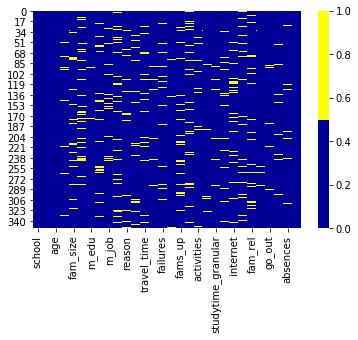

In [21]:
# желтый - пропущенные данные, синий - не пропущенные
colors = ['#000099', '#ffff00']
sns.heatmap(df.isnull(), cmap=sns.color_palette(colors))

Видно, что пропуски распределены практически равномерно и в разных столбцах на разных строчках. 
Поэтому точечное удаление отдельных строк приведет к значительному сокращению датасета. 

Итак, 
попробуем автоматический анализ и обработку:

In [22]:
def primary_analysis2(col_name):
    ''' Функция предназначена для автоматического определения и 

    ЗАМЕНЫ пропущенных и недопустимых значений на моду или медиану,

    а также для вывода уникальных значений.

    '''

    print('Первичный анализ и обработка столбца:', col_name)
    a_val = []
    n = df[col_name].isnull().sum()
    if n > 0:

        print('В столбце', col_name, 'обнаружено пропусков:', n,
              ' или', round(100*n/len(df[col_name]), 0), '% данных')
        if var_class[col_name] == 'quant':
            df[col_name].fillna(df[col_name].median(), inplace=True)
            print('Пропуски заполнены медианой столбца:',
                  df[col_name].median())
        else:
            df[col_name].fillna(df[col_name].mode()[0], inplace=True)
            print('Пропуски заполнены модой столбца:', df[col_name].mode()[0])

    if not var_class[col_name] == 'nom':
        if valid_lims[col_name] not in ['unknown']:
            if valid_lims[col_name] in ['non-negative']:
                if (df[col_name] < 0).any():
                    a_val = df[col_name][df[col_name] < 0].tolist()
                    median = df[col_name].median()
                    df[col_name] = df[col_name].apply(
                        lambda x: x if x >= 0 else median)
                    print('Аномальные значения: \n', a_val)
                    print('Аномальные значения заполнены медианой столбца:',
                          df[col_name].median())
            else:
                if (df[col_name].isin(valid_lims[col_name]) == False).any():
                    a_val = df[col_name][df[col_name].isin(
                        valid_lims[col_name]) == False].tolist()
                    mode = df[col_name].mode()[0]
                    df[col_name] = df[col_name].apply(
                        lambda x: x if x in valid_lims[col_name] else mode)
                    print('Аномальные значения: \n', a_val)
                    print('Аномальные значения заполнены модой столбца:',
                          df[col_name].mode()[0])
        if not a_val:
            print('Аномальных значений не обнаружено')

    print('Уникальные значения:')
    print(pd.DataFrame(df[col_name].value_counts()))
    print('*****************************************************************\n\n')

In [23]:
for col_name in df.columns:
    primary_analysis2(col_name)

Первичный анализ и обработка столбца: school
Уникальные значения:
    school
GP     311
MS      41
*****************************************************************


Первичный анализ и обработка столбца: sex
Уникальные значения:
   sex
F  182
M  170
*****************************************************************


Первичный анализ и обработка столбца: age
Аномальных значений не обнаружено
Уникальные значения:
    age
16   96
17   90
15   76
18   69
19   16
20    3
22    1
21    1
*****************************************************************


Первичный анализ и обработка столбца: address
В столбце address обнаружено пропусков: 14  или 4.0 % данных
Пропуски заполнены модой столбца: U
Уникальные значения:
   address
U      279
R       73
*****************************************************************


Первичный анализ и обработка столбца: fam_size
В столбце fam_size обнаружено пропусков: 24  или 7.0 % данных
Пропуски заполнены модой столбца: GT3
Уникальные значения:
     fam_si

Проанализировав уникальные значения можно сделать вывод, что дополнительное уточнение наличия выбросов требуется только для количественной переменной -'absences'.

0.0      74
4.0      62
2.0      60
6.0      30
8.0      20
10.0     17
12.0     12
14.0     12
3.0       7
16.0      7
7.0       6
5.0       5
18.0      5
20.0      4
22.0      3
9.0       3
1.0       3
15.0      2
13.0      2
11.0      2
25.0      1
54.0      1
385.0     1
26.0      1
56.0      1
24.0      1
212.0     1
21.0      1
75.0      1
30.0      1
19.0      1
38.0      1
40.0      1
23.0      1
17.0      1
28.0      1
Name: absences, dtype: int64

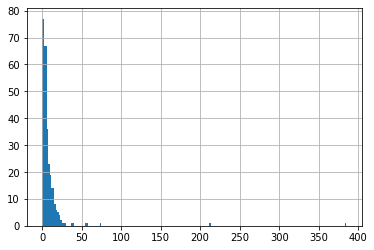

In [24]:
df['absences'].hist(bins=200)
df['absences'].value_counts()

Распределение напоминает геометрическое или экспоненциальное, и хотя перцентильное определение выбросов здесь возможно (хотя и специфическое по отношению к модели распределения), будет проще воспользоваться здравым смыслом и просто отбросить два дальних значения : 212 и 385 

In [25]:
df = df[df['absences'] < 212]

Количественная переменная 'age' находится в рамках допустимых значений и дополнительной обработки не требует

16    95
17    90
15    76
18    69
19    16
20     2
22     1
21     1
Name: age, dtype: int64

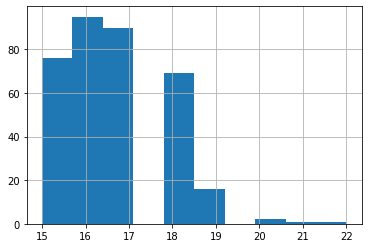

In [26]:
df['age'].hist()
df['age'].value_counts()

Посмотрим на распределение признаков в ранговых переменных:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C6CCB48>,
      dtype=object)

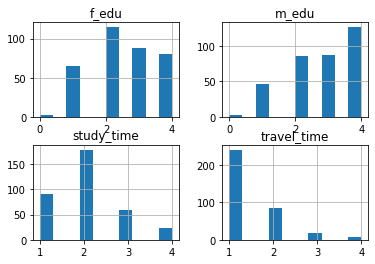

In [27]:
df[rank_list[:4]].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C61B288>,
      dtype=object)

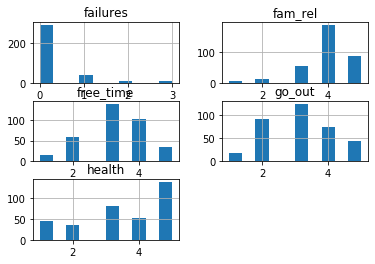

In [28]:
df[rank_list[4:]].hist()

Визуальный анализ распределений ранговых переменных подтвердил отсутствие аномалий после предварительной обработки данных.

Дополнительно можно сказать, что выборки переменой failures с значениями 2,3 недостаточно большие, поэтому надо будет с осторожностью относится к результатам с участием этой переменной. 

Посмотрим также еще один неуказанный в описании столбец 'studytime_granular'

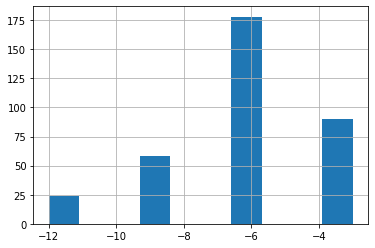

In [29]:
df['studytime_granular'].hist()

Проведем корреляционный анализ количественных признаков

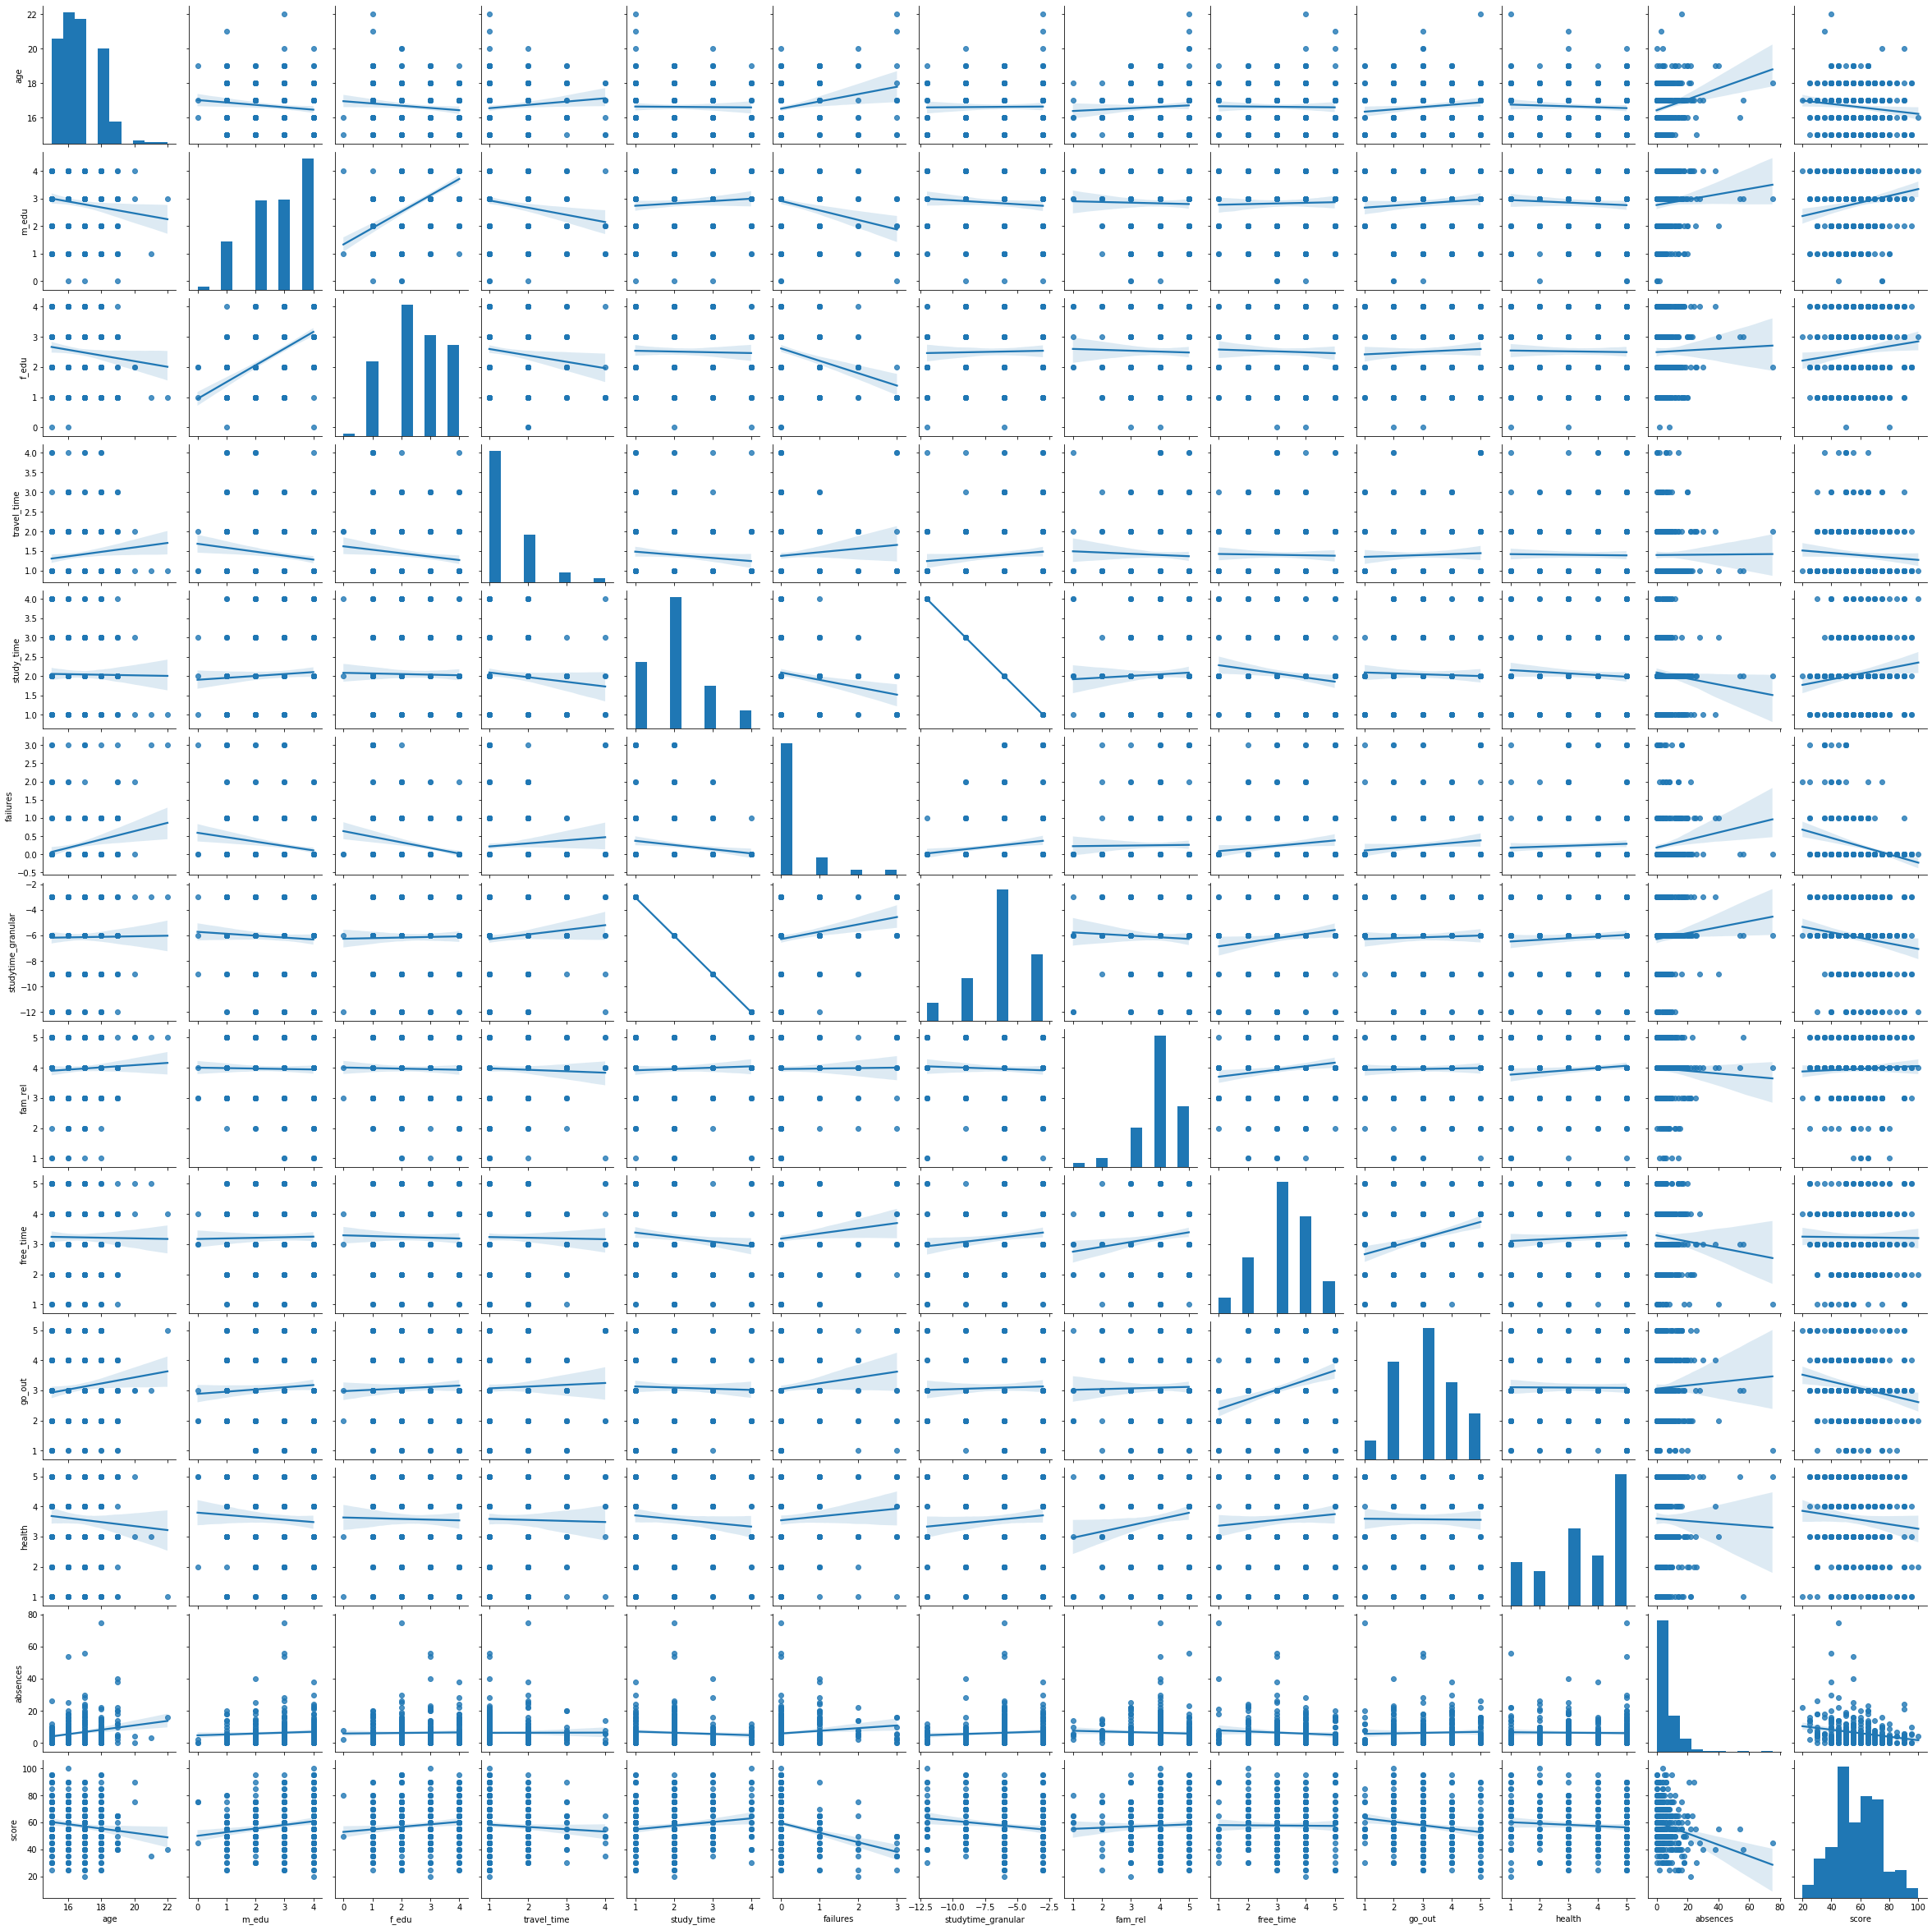

In [30]:
sns.pairplot(df, kind='reg')

Сразу можно увидеть линейную зависимость столбцов 'study_time' и 'studytime_granular'. Поэтому, удаляем столбец 'studytime_granular' из датасета:

In [31]:
df.drop(['studytime_granular'], axis=1, inplace=True)

Оценим визуально наличие корреляций для количественных параметров:

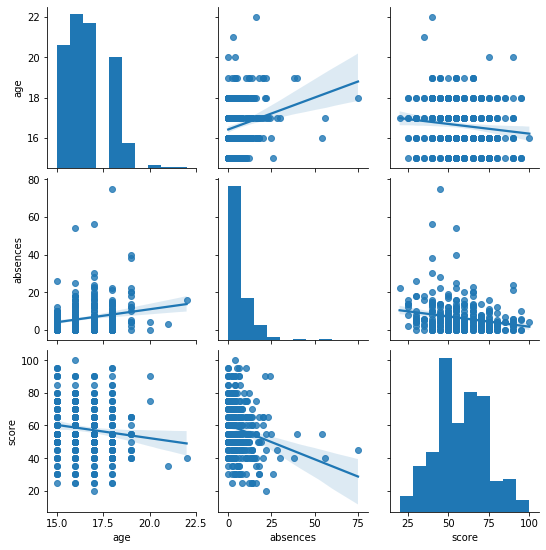

In [32]:
sns.pairplot(df[quant_list], kind='reg')

Посчитаем корреляцию для количественных переменных:

In [33]:
df[quant_list].corr()

,age,absences,score
age,1.000000,0.208898,-0.125073
absences,0.208898,1.000000,-0.214358
score,-0.125073,-0.214358,1.000000


Имеется относительно слабая отрицательная зависимость возраста и количества пропущенных занятий с итоговым баллом, что в общем логично.

Так как у нас имеется большое количество ранговых переменных, то обычная пирсоновская корреляция не применима. Поэтому можно применить ранговую кореляцию, например, Спирмана.

In [34]:
df[rank_list+['score']].corr(method='spearman')

,m_edu,f_edu,travel_time,study_time,failures,fam_rel,free_time,go_out,health,score
m_edu,1.000000,0.581749,-0.133525,0.065885,-0.193599,0.004896,0.025589,0.078395,-0.053753,0.181781
f_edu,0.581749,1.000000,-0.116798,0.006743,-0.222145,-0.000167,-0.029247,0.058747,-0.025144,0.131371
travel_time,-0.133525,-0.116798,1.000000,-0.107227,0.075892,-0.048511,-0.028376,0.011058,-0.054017,-0.073119
study_time,0.065885,0.006743,-0.107227,1.000000,-0.136111,0.065163,-0.111892,-0.037833,-0.089109,0.123445
failures,-0.193599,-0.222145,0.075892,-0.136111,1.000000,-0.010540,0.118954,0.131773,0.079366,-0.287124
fam_rel,0.004896,-0.000167,-0.048511,0.065163,-0.010540,1.000000,0.137373,0.020604,0.094382,0.063708
free_time,0.025589,-0.029247,-0.028376,-0.111892,0.118954,0.137373,1.000000,0.283655,0.083429,-0.014790
go_out,0.078395,0.058747,0.011058,-0.037833,0.131773,0.020604,0.283655,1.000000,-0.012722,-0.178722
health,-0.053753,-0.025144,-0.054017,-0.089109,0.079366,0.094382,0.083429,-0.012722,1.000000,-0.059915
score,0.181781,0.131371,-0.073119,0.123445,-0.287124,0.063708,-0.014790,-0.178722,-0.059915,1.000000


Можно отметить слабую положительную корреляцию с образованием родителей, временем на учебу помимо школы. Для получения более высоких баллов можно также порекомендовать меньше проводить времени с друзьями).
Наивысшая корреляция (0.58) - между образованием родителей, что дает основания заполнять пропуски с помощью значений из колонки супруга. Также,  для сокращения размерности входных переменных можно попробовать получить новую переменную p_edu = max(m_edu,f_edu), которая берет максимальное образование от обоих родителей:


In [35]:
df['p_edu'] = df[['f_edu', 'm_edu']].apply(
    lambda x: x[0] if x[0] > x[1] else x[1], 1)
df[['p_edu', 'score']].corr(method='spearman')

,p_edu,score
p_edu,1.000000,0.196227
score,0.196227,1.000000


Новый синтезированный признак оказался несколько более влияющим, чем m_edu и f_edu.


Учитывая сомнения относительно влияния переменной failures с корреляцией (-0.28), можно перевести ее в номинативную переменную:

In [36]:
df['failures'] = df['failures'].apply(lambda x: x if x == 0 else 1)
nom_list.append('failures')

Проанализируем теперь номинативные переменные:

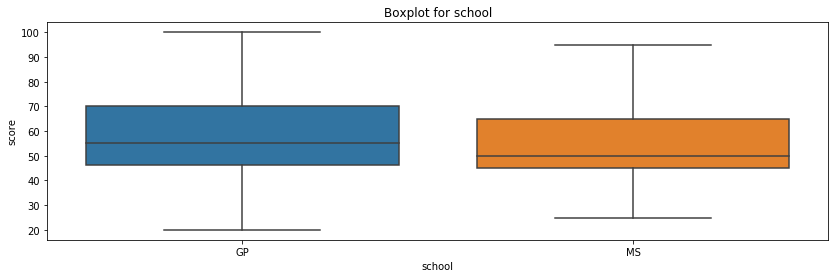

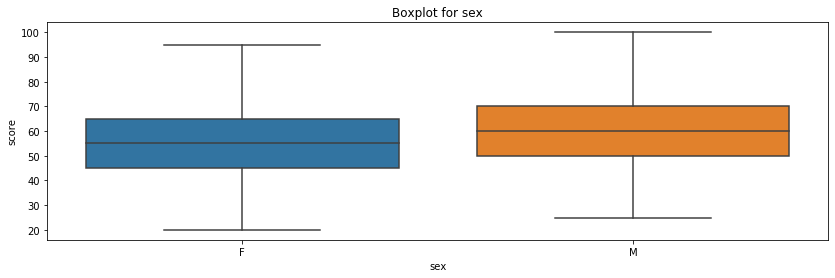

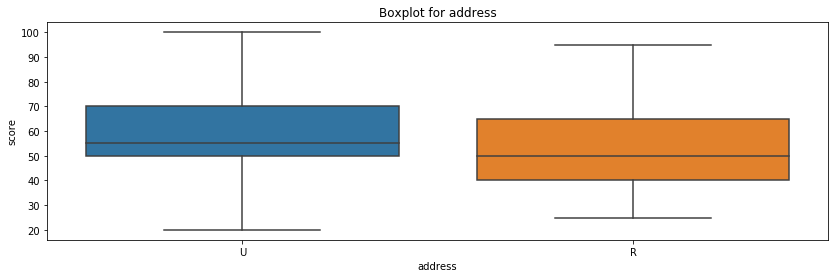

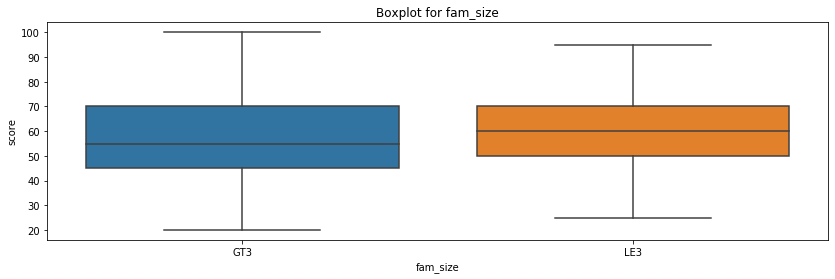

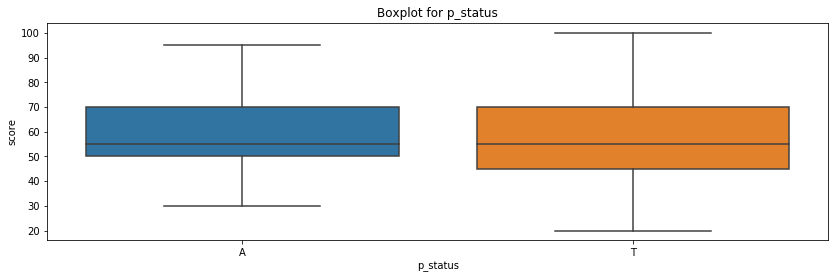

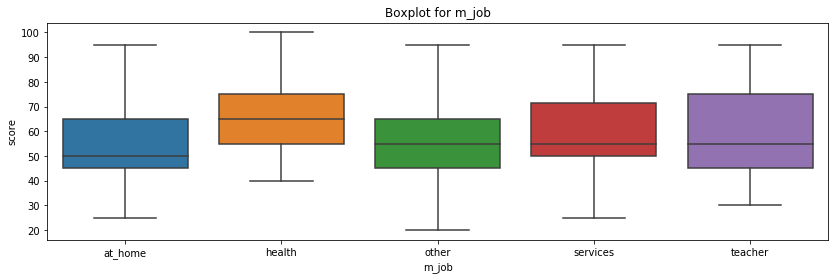

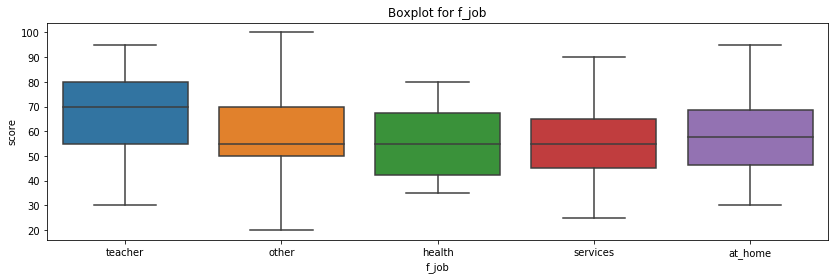

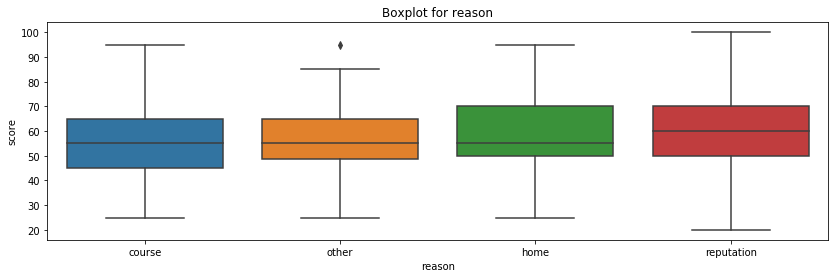

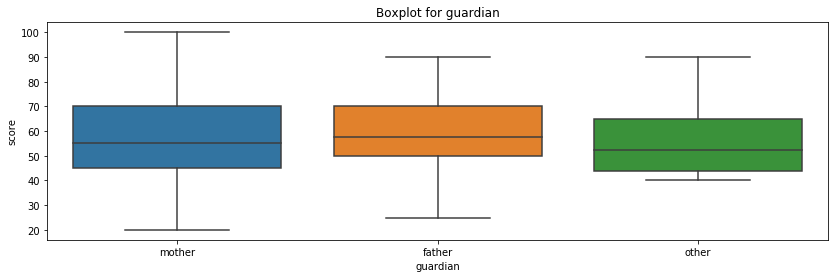

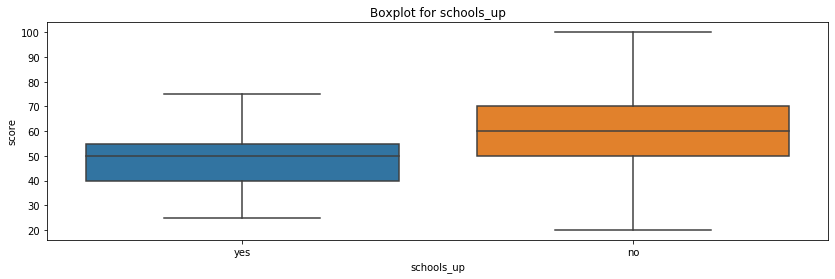

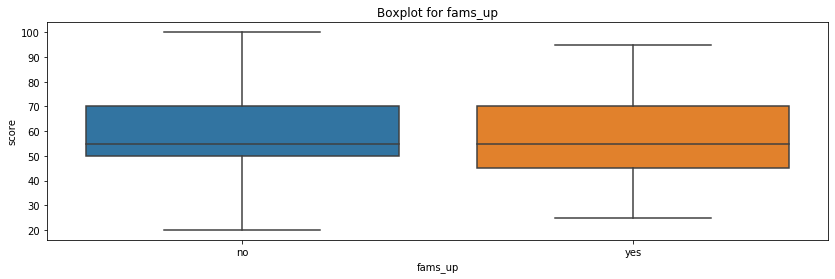

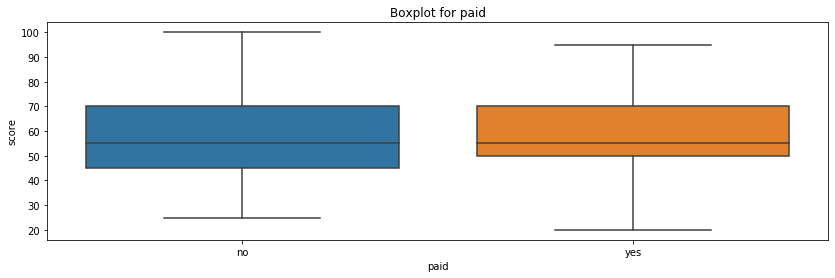

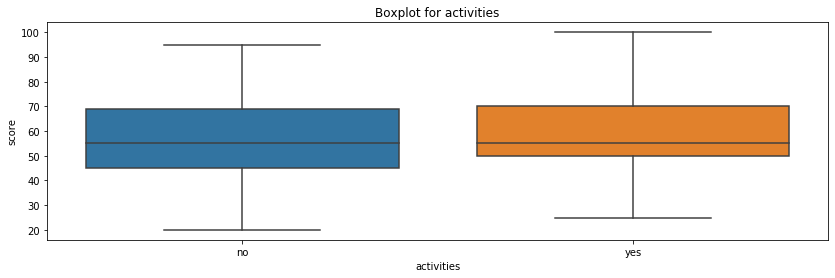

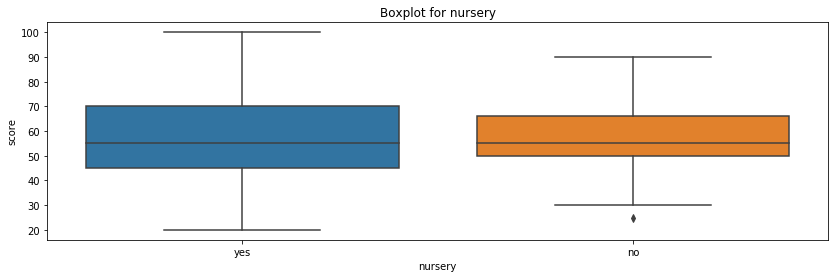

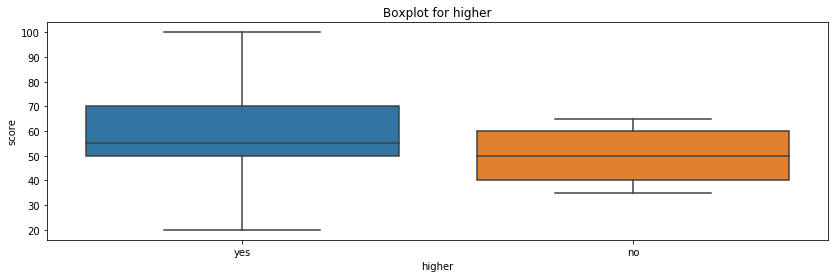

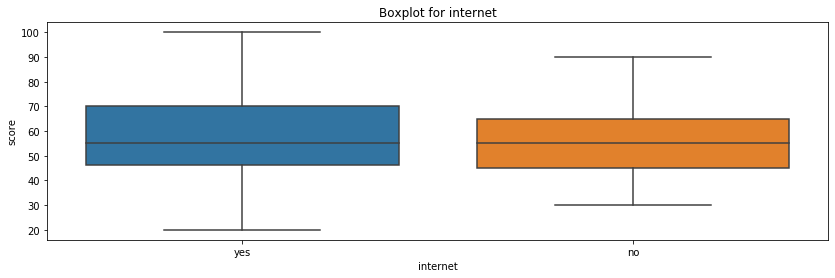

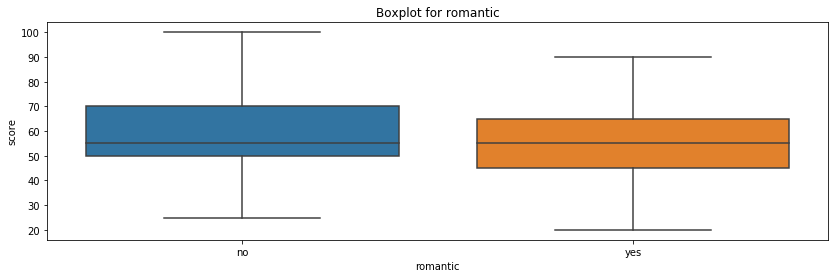

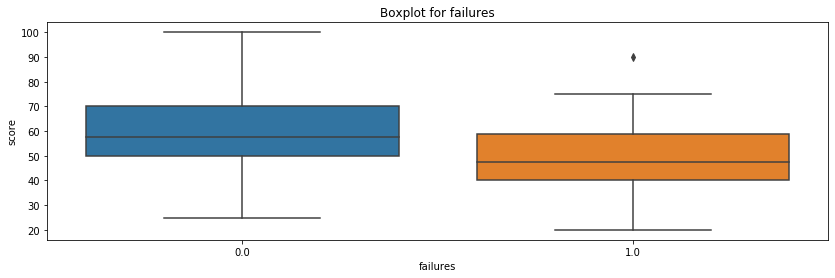

In [37]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:])],
                ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()


for col in nom_list:
    get_boxplot(col)

На основе визуального анализа боксплотов можно сделать вывод о влиянии следующих признаков:
'sex', 'address', 'm_job', 'f_job', 'schools_up', 'higher' и 'failures'.

Проверим это с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения 'score' по различным параметрам неразличимы:

In [38]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    alfa = 0.05
    for comb in combinations_all:
        p_value = ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                            df.loc[df.loc[:, column] == comb[1], 'score']).pvalue
        if p_value <= alfa/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия: pvalue =', round(
                p_value, 4), ' < ', alfa/len(combinations_all), ' для колонки', column)
            stat_list.append(column)
            break

In [39]:
stat_list = []  # создадим список для статистически значимых номинативных переменных
for col in nom_list:
    get_stat_dif(col)

Найдены статистически значимые различия: pvalue = 0.0393  <  0.05  для колонки sex
Найдены статистически значимые различия: pvalue = 0.0094  <  0.05  для колонки address
Найдены статистически значимые различия: pvalue = 0.0047  <  0.005  для колонки m_job
Найдены статистически значимые различия: pvalue = 0.0  <  0.05  для колонки schools_up
Найдены статистически значимые различия: pvalue = 0.0  <  0.05  для колонки failures


Построим гистограммы распределений score для различных значений влияющих переменных(по сути, аналоги боксплотов построенных выше, только более подробные):

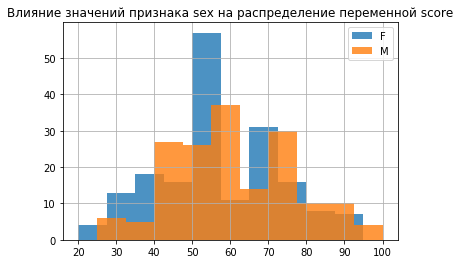

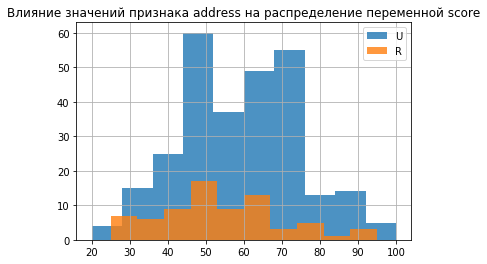

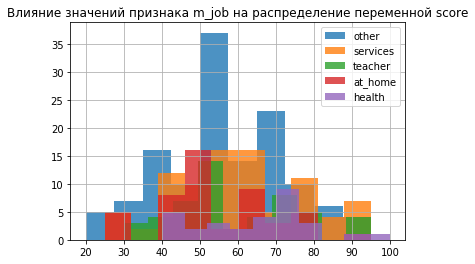

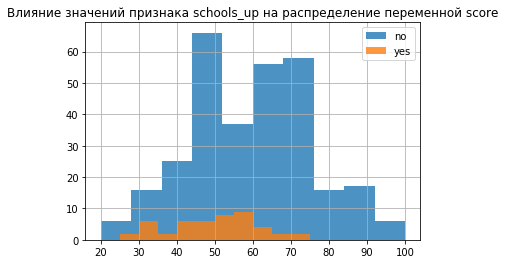

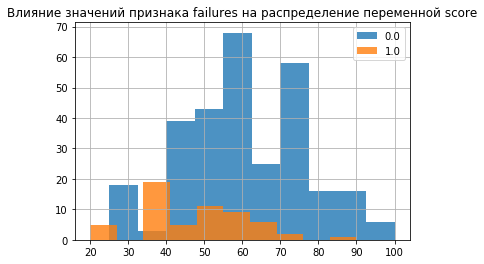

In [40]:
def plot_stat_differences(column):
    fig, ax = plt.subplots(figsize=(6, 4))
    for x in df[n].value_counts().keys().tolist():
        df[df[n] == x]['score'].hist(alpha=0.8, label=x)
    plt.legend()
    t = plt.title('Влияние значений признака '+n +
                  ' на распределение переменной score')


for n in stat_list:
    plot_stat_differences(n)

Действительно, можно подробно видеть различия в распределениях в зависимости от значений влияющих факторов.

Однако по сравнению с визуальной оценкой по боксплотам наш список влияющих номинативных признаков уменьшился за счет 'higher' и 'f_job' (влияние которых представляется вполне логичным). Если попробовать немного изменить коэффициент значимости (alfa = 0.07, вместо 0.05) в функции теста Стьюдента, то визуальный список влияющих номинативных факторов определенный по боксплотам подтвердится:
'sex', 'address', 'm_job', 'f_job', 'schools_up', 'higher' и 'failures'. Причем, сильнее всего оказалось отрицательное влияние 'failures' (как и в случае с ранговой корреляцией - (- 0.28))

Итак, по итогам проведенного анализа можно отобрать следующие влияющие признаки:
 